# Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta

from config import Config
config=Config()

from footkit import Preprocess, Parser, Validation, Calculation, OddsParser, PlotPredict, InstaBot, FeatureSelector
from footkit.utils import report_validation

from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
# making the workspace wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# more information in the tables
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',150)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

import asyncio

# Парсер событий из UnderStat.com, читаем через api
* сбор данных, агрегация, генерация признаков
* если нужно обновить update_data = True

In [2]:
parser = Parser(Config)
df, teams_df = await parser.get_parse_data(update_data=False, resaved_data=True)
# asyncio.get_event_loop().run_until_complete(parser.get_parse_data(update_data=False, resaved_data=True))
print('Прогнозируем:', parser.predict_targets)

preprocess=Preprocess(Config, df, teams_df)
teams_df=preprocess.get_teams_df()

df, engineering_features = preprocess.create_features()
df_targets, targets = preprocess.get_target_on_df_eng('FTHG', 'FTAG')

Прогнозируем: ['W', 'L', '1X', '2X', 'Total Less 1.5', 'Total Less 2.5', 'Total Less 3.5', 'Total More 1.5', 'Total More 2.5', 'Total More 3.5']
до обработки Shape==1:  False
после обработки Shape==1:  False


# Парсер OddsPortal.com (selenium+beautySoup)
* если нужно обновить from_file = False

In [3]:
# df_odds, df_bookmakers = Odds(Config).get_last_update_scrapper(df)
odds = OddsParser(Config, last_update=True)
df_odds, df_bookmakers = odds.get_last_update_scrapper(
    df,
    season=2020,
    url='https://www.oddsportal.com/login/',
    username='user',
    password='pass',
    proxy=False,
    headless=False,
    from_file=True,
)

./Parser/data\2020_08_16 parser_last_update.xlsx


#### пример простой модели, подаем дату и один таргет

In [4]:
# simple model
run_model = Validation(Config).run_model
start_date = dt.now()
# pd.to_datetime('2020-02-21').date()
# dt.now()
# pd.to_datetime('2018-12-01').date() # start_date = datetime.datetime.now()
target='2X'

features = list(set(engineering_features + ['HomeTeamId', 'AwayTeamId', 'Season'])-set(['Date']))

df = df[~df.index.duplicated(keep='first')]
df_targets = df_targets[~df_targets.index.duplicated(keep='first')]
y_pred, res, model_tc, oof_pred, all_val_test_index = run_model(
    df=df,
    df_targets=df_targets,
    start_date=start_date,
    target=target,
    features=features,
    val_function=roc_auc_score,
    timeseries=False,
    num_splits=5,
    plot_importances=False,
    exp_target=False,
    verbose=True,
    cv_kfold='lastweek',
    model_name='lightgbm'
)

report_validation(df, df_targets, target, oof_pred, y_pred)


Run model, calc 2X with cv per lastweek
****************************************
2020-08-23
Learn set: 8179 
Target: 2X 
min date:2016-07-30 
max date:2020-08-15 
Weekend set: 14 
min day: 2020-08-18 
max day: 2020-08-22
val train index from 2016-07-30 to 2020-07-11 and shape 8012
val test index from 2020-07-12 to 2020-07-18 and shape 66
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.600186	valid_1's binary_logloss: 0.58827
[200]	training's binary_logloss: 0.575948	valid_1's binary_logloss: 0.579099
[300]	training's binary_logloss: 0.555836	valid_1's binary_logloss: 0.574467
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.562707	valid_1's binary_logloss: 0.573002
Fold: 1  score: 0.766
val train index from 2016-07-30 to 2020-07-18 and shape 8078
val test index from 2020-07-19 to 2020-07-25 and shape 49
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.600019	valid_1's 

### Прогнозируем все predict_targets из config.py

In [5]:
start_date = dt.now()
# pd.to_datetime('2020-02-21').date()# dt.now()# pd.to_datetime('2018-12-01').date()
features = list(set(engineering_features + ['HomeTeamId', 'AwayTeamId', 'Season'])-set(['Date']))
calc_forecast_on_targets = Validation(Config).calc_forecast_on_targets
df_pred, df_pred_cutoff = calc_forecast_on_targets(
    df=df[df['Date']>pd.to_datetime('2018-08-01')], # df,
    df_targets=df_targets,
    features=features,
    start_date=start_date,
    val_function=roc_auc_score,
    num_splits=5,
    plot_importances=False,
    print_report=False,
    verbose=True
)


Run model, calc W with cv per lastweek
****************************************
2020-08-23
Learn set: 4039 
Target: W 
min date:2018-08-03 
max date:2020-08-15 
Weekend set: 14 
min day: 2020-08-18 
max day: 2020-08-22
val train index from 2018-08-03 to 2020-07-11 and shape 3872
val test index from 2020-07-12 to 2020-07-18 and shape 66
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.578925	valid_1's binary_logloss: 0.600905
[200]	training's binary_logloss: 0.538889	valid_1's binary_logloss: 0.587306
[300]	training's binary_logloss: 0.505559	valid_1's binary_logloss: 0.567601
[400]	training's binary_logloss: 0.473729	valid_1's binary_logloss: 0.564218
[500]	training's binary_logloss: 0.445168	valid_1's binary_logloss: 0.559372
[600]	training's binary_logloss: 0.41922	valid_1's binary_logloss: 0.557829
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.423122	valid_1's binary_logloss: 0.555896
Fold: 1  score: 0.7763
val

2020-08-23
Learn set: 4039 
Target: 2X 
min date:2018-08-03 
max date:2020-08-15 
Weekend set: 14 
min day: 2020-08-18 
max day: 2020-08-22
val train index from 2018-08-03 to 2020-07-11 and shape 3872
val test index from 2020-07-12 to 2020-07-18 and shape 66
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.578925	valid_1's binary_logloss: 0.600905
[200]	training's binary_logloss: 0.538889	valid_1's binary_logloss: 0.587306
[300]	training's binary_logloss: 0.505559	valid_1's binary_logloss: 0.567601
[400]	training's binary_logloss: 0.473729	valid_1's binary_logloss: 0.564218
[500]	training's binary_logloss: 0.445168	valid_1's binary_logloss: 0.559372
[600]	training's binary_logloss: 0.41922	valid_1's binary_logloss: 0.557829
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.423122	valid_1's binary_logloss: 0.555896
Fold: 1  score: 0.7763
val train index from 2018-08-03 to 2020-07-18 and shape 3938
val test index from 20

[100]	training's binary_logloss: 0.53007	valid_1's binary_logloss: 0.559805
[200]	training's binary_logloss: 0.490277	valid_1's binary_logloss: 0.551067
[300]	training's binary_logloss: 0.455821	valid_1's binary_logloss: 0.543877
[400]	training's binary_logloss: 0.424599	valid_1's binary_logloss: 0.544132
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.433734	valid_1's binary_logloss: 0.53937
Fold: 1  score: 0.7141
val train index from 2018-08-03 to 2020-07-18 and shape 3938
val test index from 2020-07-19 to 2020-07-25 and shape 49
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.529758	valid_1's binary_logloss: 0.583697
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.591365	valid_1's binary_logloss: 0.559328
Fold: 2  score: 0.6115
val train index from 2018-08-03 to 2020-07-25 and shape 3987
val test index from 2020-07-26 to 2020-08-01 and shape 31
Training until validation scores don't improve fo

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.529758	valid_1's binary_logloss: 0.583697
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.591365	valid_1's binary_logloss: 0.559328
Fold: 2  score: 0.6115
val train index from 2018-08-03 to 2020-07-25 and shape 3987
val test index from 2020-07-26 to 2020-08-01 and shape 31
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.531263	valid_1's binary_logloss: 0.699147
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.562016	valid_1's binary_logloss: 0.693093
Fold: 3  score: 0.5214
val train index from 2018-08-03 to 2020-08-01 and shape 4018
val test index from 2020-08-02 to 2020-08-08 and shape 7
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.531873	valid_1's binary_logloss: 0.562322
[200]	training's binary_logloss: 0.492542	valid_1's binary_logloss: 0.540408
[3

### добавляем кэфы, считаем ROI, выбираем лучший вариант по threshold (cutoff), и пороги выставленные в файле config.py

In [6]:
CalcProf = Calculation(Config)

df_roi, df_results = CalcProf.calc_profit(
    df_odds=df_odds,
    df_bookmakers=df_bookmakers,
    df_pred=df_pred,
    df_pred_round=df_pred_cutoff,
    df_targets=df_targets,
    # predict_targets=predict_targets,
    rename=False,#'Interval'
    df=df,
    # info_features=info_features,
    concat_with_info_df=False,
    prev_df_results=False
)

df_odds_interval, df_pred_round_predel = CalcProf.set_optimize_proba_interval(df_odds, df_pred)
df_roi_interval, df_results = CalcProf.calc_profit(
    df_odds=df_odds_interval,
    df_bookmakers=df_bookmakers,
    df_pred=df_pred,
    df_pred_round=df_pred_round_predel,
    df_targets=df_targets,
    # predict_targets=predict_targets,
    rename='Interval',
    df=df,
    # info_features=info_features,
    concat_with_info_df=True,
    prev_df_results=df_results
)

time = str(dt.now().date())
time = time[:4]+'_'+time[5:7]+'_'+time[8:10]
df_results.to_pickle('./Predictions/'+time+' prediction.pkl')
df_results.to_excel('./Predictions/'+time+' prediction.xlsx', index=None)

# print(df_results[['Profit','Interval Profit']].sum())
# print(format(df_results['Interval Profit'].sum()/(df_results['Interval Predict']*100).sum(),'.1%'))

In [7]:
df_results[['HomeTeam', 'AwayTeam', 'Best Roi Bet', 'Coef', 'Proba', 'Best Roi']]

,HomeTeam,AwayTeam,Best Roi Bet,Coef,Proba,Best Roi
IdMatch,,,,,,
14016,Ural,Lokomotiv Moscow,1X,2.080,0.700,0.455
14017,FC Ufa,Spartak Moscow,L,2.020,0.560,0.131
14019,Dinamo Moscow,FC Rostov,W,2.480,0.578,0.433
14015,FC Krasnodar,Arsenal Tula,Total More 2.5,2.070,0.540,0.117


# Рисуем картинки с прогнозом

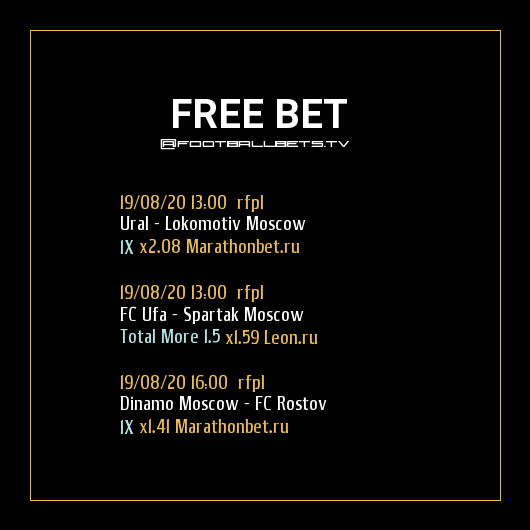

In [8]:
PltPred = PlotPredict(Config)
PltPred.get_plot_predict(
    paint_df=df_results,
    hometeam='HomeTeam',
    awayteam='AwayTeam',
    leaguename='LeagueName',
    bookmaker='Interval Bookmaker',
    bet='Interval Best Roi Bet',
    betcoef='Interval Coef',
    datename='DateTime',
    proba='Interval Proba',
    show_pictures=True,
    clear_pic_path=True,
)

# Выкладываем в instagram
* генерируем хештег из вывески матча
* канал: https://www.instagram.com/footballbets.tv/



- 2020-08-16 21:49:51,387 - INFO - Photo './Pictures/prediction_pics/19_08_20 Ural - Lokomotiv Moscow, FC Ufa - Spartak Moscow, Dinamo Moscow - FC Rostov.jpg' is uploaded.
- ['#Ural', '#Lokomotiv', '#Moscow', '#FC', '#Ufa', '#Spartak', '#Moscow', '#Dinamo', '#Moscow', '#FC', '#Rostov#Football', '#Bets', '#Recommendations', '#stavki']

In [9]:
insta=InstaBot(Config)
insta.login_bot()
while True:
    insta.autoposting(insta.upload_photos, path_medias='./Pictures/prediction_pics/', fromCaptions='File')
    insta.sleep(100)

2020-08-16 21:53:50,138 - INFO - Instabot version: 0.117.0 Started
2020-08-16 21:53:50,140 - INFO - Not yet logged in starting: PRE-LOGIN FLOW!
2020-08-16 21:53:53,405 - INFO - Logged-in successfully as 'footballbets.tv'!
2020-08-16 21:53:53,406 - INFO - LOGIN FLOW! Just logged-in: True


FOUND: w:530 h:530 r:1.0


2020-08-16 21:54:26,086 - INFO - Photo './Pictures/prediction_pics/19_08_20 Ural - Lokomotiv Moscow, FC Ufa - Spartak Moscow, Dinamo Moscow - FC Rostov.jpg' is uploaded.


 ['#Ural', '#Lokomotiv', '#Moscow', '#FC', '#Ufa', '#Spartak', '#Moscow', '#Dinamo', '#Moscow', '#FC', '#Rostov#Football', '#Bets', '#Recommendations', '#stavki']


KeyboardInterrupt: 